Loading data from: /standard/sds_baek_energetic/Eagle/Eagle_dataset/Spl/13/1

Data contains 990 timesteps.
--- Visualizing Timestep: 0 ---

Data for timestep loaded successfully.
  Node Coords (x): (3354,)
  Node Coords (y): (3354,)
  Triangles: (6541, 3)
  Velocity: (3354,)

--- Sanity Check ---
  Min triangle index: 0
  Max triangle index: 3353
  Number of nodes: 3354
----------------------

Generating plot...

Successfully saved visualization to: spline_plot_timestep_0.png


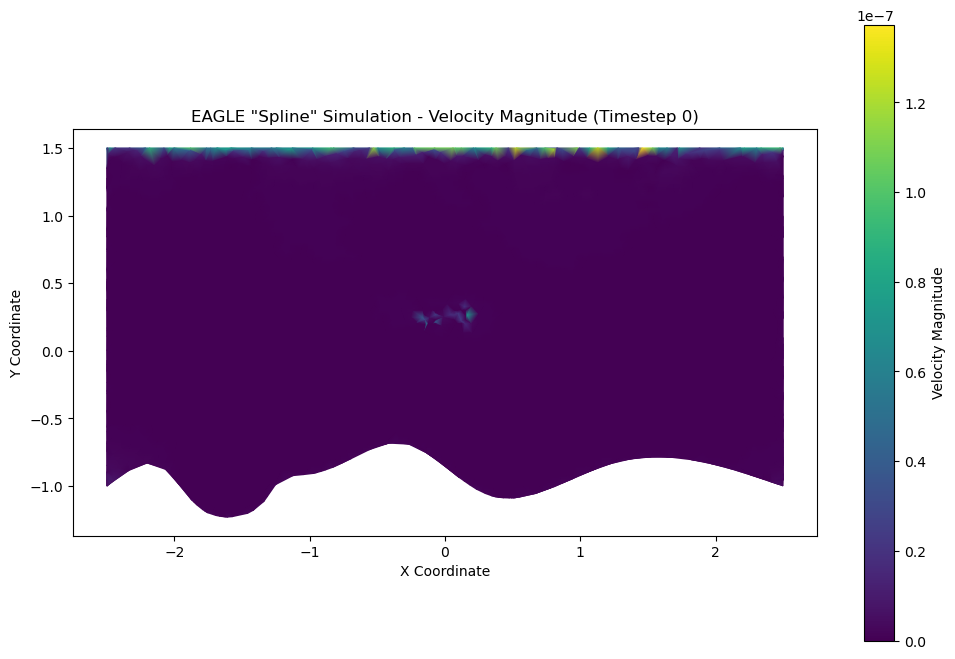

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Settings ---
# We have 990 timesteps (0 to 989). Let's plot the first one.
TIMESTEP_TO_PLOT = 0 
# You can change this to 100, 500, or -1 (for the last)

# --- Define File Paths ---
data_path = "/standard/sds_baek_energetic/Eagle/Eagle_dataset/Spl/13/1"
sim_file = os.path.join(data_path, "sim.npz")
triangles_file = os.path.join(data_path, "triangles.npy")

print(f"Loading data from: {data_path}")

try:
    # --- Load Data ---
    data = np.load(sim_file)
    triangles_all = np.load(triangles_file)

    print(f"\nData contains {data['pointcloud'].shape[0]} timesteps.")
    print(f"--- Visualizing Timestep: {TIMESTEP_TO_PLOT} ---")

    # --- Extract Data for ONE Timestep ---
    
    # Get mesh coordinates for this timestep
    # Shape (3072, 2)
    mesh_pos = data['pointcloud'][TIMESTEP_TO_PLOT]
    x_coords = mesh_pos[:, 0]  # Shape (3072,)
    y_coords = mesh_pos[:, 1]  # Shape (3072,)
    
    # Get velocity components for this timestep
    vx = data['VX'][TIMESTEP_TO_PLOT]  # Shape (3072,)
    vy = data['VY'][TIMESTEP_TO_PLOT]  # Shape (3072,)
    
    # Get triangles for this timestep
    # Shape (5983, 3)
    triangles_single = triangles_all[TIMESTEP_TO_PLOT]
    
    # Calculate velocity magnitude
    velocity_magnitude = np.sqrt(vx**2 + vy**2)

    print("\nData for timestep loaded successfully.")
    print(f"  Node Coords (x): {x_coords.shape}")
    print(f"  Node Coords (y): {y_coords.shape}")
    print(f"  Triangles: {triangles_single.shape}")
    print(f"  Velocity: {velocity_magnitude.shape}")

    # --- Pre-plot Sanity Check ---
    min_tri_index = np.min(triangles_single)
    max_tri_index = np.max(triangles_single)
    num_nodes = x_coords.shape[0]
    
    print("\n--- Sanity Check ---")
    print(f"  Min triangle index: {min_tri_index}")
    print(f"  Max triangle index: {max_tri_index}")
    print(f"  Number of nodes: {num_nodes}")
    
    if max_tri_index >= num_nodes:
        print(f"  ERROR: Max triangle index ({max_tri_index}) is out of bounds for {num_nodes} nodes.")
    if min_tri_index < 0:
        print(f"  ERROR: Min triangle index ({min_tri_index}) is negative.")
    print("----------------------\n")


    # --- Create Visualization ---
    print("Generating plot...")
    
    plt.figure(figsize=(12, 8))
    
    # --- CORRECTED PLOT CALL ---
    # This is the robust way to call tripcolor for Gouraud shading:
    # Pass (x, y, C) as positional arguments, where C has one value per node.
    # Pass 'triangles' as a keyword argument.
    plt.tripcolor(
        x_coords, 
        y_coords, 
        velocity_magnitude,  # C (node values) as 3rd positional arg
        triangles=triangles_single, # Triangles as keyword arg
        cmap='viridis',
        shading='gouraud'
    )
    
    # --- Customize Plot ---
    plt.title(f'EAGLE "Spline" Simulation - Velocity Magnitude (Timestep {TIMESTEP_TO_PLOT})')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.colorbar(label='Velocity Magnitude')
    plt.gca().set_aspect('equal', adjustable='box')
    
    # --- Save Plot ---
    output_filename = f"spline_plot_timestep_{TIMESTEP_TO_PLOT}.png"
    plt.savefig(output_filename)
    
    print(f"\nSuccessfully saved visualization to: {output_filename}")

except FileNotFoundError as e:
    print(f"\nError: File not found.")
    print(e)
except IndexError:
    print(f"\nError: Timestep {TIMESTEP_TO_PLOT} is out of range.")
    print(f"Please choose a value between 0 and {data['pointcloud'].shape[0] - 1}.")
except Exception as e:
    print(f"\nAn unexpected error occurred:")
    print(e)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

# --- Animation Settings ---
# Let's animate the first 100 frames (timesteps 0-99).
# Change this to see more or fewer frames. 990 is the max.
NUM_FRAMES_TO_ANIMATE = 990
# Frames per second for the output GIF
FPS = 15

# --- Define File Paths ---
data_path = "/standard/sds_baek_energetic/Eagle/Eagle_dataset/Spl/1/1"
sim_file = os.path.join(data_path, "sim.npz")
triangles_file = os.path.join(data_path, "triangles.npy")

print(f"Loading data from: {data_path}")

try:
    # --- Load Data (load into memory) ---
    # We load all data first to make animation smoother
    print("Loading data into memory (this may take a moment)...")
    data = np.load(sim_file)
    triangles_all = np.load(triangles_file)
    
    # Extract all data into variables
    pointcloud_all = data['pointcloud']
    vx_all = data['VX']
    vy_all = data['VY']
    
    num_timesteps, num_nodes, _ = pointcloud_all.shape
    print(f"Data contains {num_timesteps} timesteps and {num_nodes} nodes.")

    if NUM_FRAMES_TO_ANIMATE > num_timesteps:
        print(f"Warning: Requested {NUM_FRAMES_TO_ANIMATE} frames, but data only has {num_timesteps}.")
        NUM_FRAMES_TO_ANIMATE = num_timesteps

    # --- Set up the Plot ---
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Find global min/max for consistent color scaling
    print("Calculating global velocity range for color consistency...")
    velocity_magnitude_all = np.sqrt(vx_all**2 + vy_all**2)
    vmin = np.min(velocity_magnitude_all[:NUM_FRAMES_TO_ANIMATE])
    vmax = np.max(velocity_magnitude_all[:NUM_FRAMES_TO_ANIMATE])
    print(f"  Velocity range: {vmin:.2f} to {vmax:.2f}")

    # --- Animation Update Function ---
    def update(frame):
        # Clear the previous frame's plot
        ax.cla()

        # Extract data for the current frame
        mesh_pos = pointcloud_all[frame]
        x_coords = mesh_pos[:, 0]
        y_coords = mesh_pos[:, 1]
        
        velocity_magnitude = velocity_magnitude_all[frame]
        triangles_single = triangles_all[frame]
        
        # --- Plot Velocity (tripcolor) ---
        ax.tripcolor(
            x_coords, 
            y_coords, 
            velocity_magnitude,
            triangles=triangles_single,
            cmap='viridis',
            shading='gouraud',
            vmin=vmin, # Use consistent color scale
            vmax=vmax
        )
        
        # --- Plot Mesh (triplot) ---
        # Overlay the mesh with thin, semi-transparent black lines
        ax.triplot(
            x_coords, 
            y_coords, 
            triangles_single,
            'k-', # 'k-' means black solid line
            lw=0.5, # lw is line width
            alpha=0.3 # alpha is transparency
        )

        # --- Customize Plot ---
        ax.set_title(f'EAGLE "Spline" Simulation - Velocity & Mesh (Timestep {frame})')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_aspect('equal', adjustable='box')
        
        # We only add the colorbar once, not in the update loop,
        # but for this setup, adding it here is simplest.
        # A more complex setup would create the colorbar outside.
        
        print(f"  Rendering frame {frame+1}/{NUM_FRAMES_TO_ANIMATE}...", end='\r')
        
        # Set return value for FuncAnimation
        return ax,

    # --- Create and Save Animation ---
    print(f"\nCreating animation for {NUM_FRAMES_TO_ANIMATE} frames...")
    
    # Create the animation object
    ani = animation.FuncAnimation(
        fig=fig, 
        func=update, 
        frames=NUM_FRAMES_TO_ANIMATE, 
        interval=1000/FPS # interval in milliseconds
    )
    
    # Add a colorbar to the figure (outside the animation loop)
    # We create a dummy mappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Velocity Magnitude')

    # Save the animation as a GIF
    output_filename = "spline_animation.gif"
    print(f"\nSaving animation to: {output_filename}")
    print("This will take some time...")
    
    ani.save(
        output_filename, 
        writer='pillow', # Use the 'pillow' writer for GIFs
        fps=FPS
    )
    
    plt.close(fig) # Close the plot to free memory
    
    print(f"\nSuccessfully saved animation to: {output_filename}")

except FileNotFoundError as e:
    print(f"\nError: File not found.")
    print(e)
except ImportError:
    print("\nError: Could not import 'matplotlib.animation'.")
    print("Please make sure Matplotlib is up to date.")
except Exception as e:
    print(f"\nAn unexpected error occurred:")
    print(e)
    if "No such file or directory: 'ffmpeg'" in str(e):
        print("\n--- HINT ---")
        print("This error might mean you need 'ffmpeg' installed for saving animations.")
    elif "writer 'pillow' not found" in str(e):
        print("\n--- HINT ---")
        print("To save GIFs, please install the 'pillow' library:")
        print("pip install pillow")

Loading data from: /standard/sds_baek_energetic/Eagle/Eagle_dataset/Spl/1/1
Loading data into memory (this may take a moment)...
Data contains 990 timesteps and 3072 nodes.
Calculating global velocity range for color consistency...
  Velocity range: 0.00 to 14.81

Creating animation for 990 frames...

Saving animation to: spline_animation.gif
This will take some time...
  Rendering frame 990/990...
Successfully saved animation to: spline_animation.gif


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

# --- Animation Settings ---
# Let's animate the first 100 frames (timesteps 0-99).
# Change this to see more or fewer frames. 990 is the max.
NUM_FRAMES_TO_ANIMATE = 100
# Frames per second for the output GIF
FPS = 15

# --- MASK SETTINGS ---
# Based on new info:
# Mask 0 = Fluid
# Mask 2 = UAV
# Mask 4, 5, 6 = Boundaries
UAV_MASK_VALUE = 2
UAV_COLOR = 'red'
# Any mask value > 2 will be considered a boundary
BOUNDARY_COLOR = 'yellow' 
UAV_SIZE = 5 # in points^2

# --- Define File Paths ---
data_path = "/standard/sds_baek_energetic/Eagle/Eagle_dataset/Spl/1/1"
sim_file = os.path.join(data_path, "sim.npz")
triangles_file = os.path.join(data_path, "triangles.npy")

print(f"Loading data from: {data_path}")

try:
    # --- Load Data (load into memory) ---
    # We load all data first to make animation smoother
    print("Loading data into memory (this may take a moment)...")
    data = np.load(sim_file)
    triangles_all = np.load(triangles_file)
    
    # Extract all data into variables
    pointcloud_all = data['pointcloud']
    vx_all = data['VX']
    vy_all = data['VY']
    mask_all = data['mask'] # <-- Load the mask data
    
    num_timesteps, num_nodes, _ = pointcloud_all.shape
    print(f"Data contains {num_timesteps} timesteps and {num_nodes} nodes.")
    
    # --- Inspect the Mask ---
    unique_mask_values = np.unique(mask_all[0])
    print(f"Inspecting mask... Unique values in frame 0: {unique_mask_values}")
    print(f"  Assuming: '0'=fluid, '{UAV_MASK_VALUE}'=UAV (Red), '>2'=Boundary (Yellow)")
    
    if NUM_FRAMES_TO_ANIMATE > num_timesteps:
        print(f"Warning: Requested {NUM_FRAMES_TO_ANIMATE} frames, but data only has {num_timesteps}.")
        NUM_FRAMES_TO_ANIMATE = num_timesteps

    # --- Set up the Plot ---
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Find global min/max for consistent color scaling
    print("Calculating global velocity range for color consistency...")
    velocity_magnitude_all = np.sqrt(vx_all**2 + vy_all**2)
    vmin = np.min(velocity_magnitude_all[:NUM_FRAMES_TO_ANIMATE])
    vmax = np.max(velocity_magnitude_all[:NUM_FRAMES_TO_ANIMATE])
    print(f"  Velocity range: {vmin:.2f} to {vmax:.2f}")

    # --- Animation Update Function ---
    def update(frame):
        # Clear the previous frame's plot
        ax.cla()

        # Extract data for the current frame
        mesh_pos = pointcloud_all[frame]
        x_coords = mesh_pos[:, 0]
        y_coords = mesh_pos[:, 1]
        
        velocity_magnitude = velocity_magnitude_all[frame]
        triangles_single = triangles_all[frame]
        mask_single = mask_all[frame] # <-- Get mask for this frame
        
        # --- Plot Velocity (tripcolor) ---
        # This plots the fluid behavior
        tripcolor_plot = ax.tripcolor(
            x_coords, 
            y_coords, 
            velocity_magnitude,
            triangles=triangles_single,
            cmap='viridis',
            shading='gouraud',
            vmin=vmin, # Use consistent color scale
            vmax=vmax
        )
        
        # --- Plot Mesh (triplot) ---
        # Overlay the mesh with thin, semi-transparent black lines
        ax.triplot(
            x_coords, 
            y_coords, 
            triangles_single,
            'k-', # 'k-' means black solid line
            lw=0.5, # lw is line width
            alpha=0.3 # alpha is transparency
        )
        
        # --- Plot UAV Nodes (Mask == 2) ---
        uav_indices = (mask_single == UAV_MASK_VALUE)
        uav_coords = mesh_pos[uav_indices]
        
        ax.scatter(
            uav_coords[:, 0], 
            uav_coords[:, 1], 
            c=UAV_COLOR, 
            s=UAV_SIZE, 
            zorder=10 # zorder=10 ensures it plots on top
        )

        # --- Plot Boundary Nodes (Mask > 2) ---
        # This will catch 4, 5, and 6
        boundary_indices = (mask_single > 2)
        boundary_coords = mesh_pos[boundary_indices]
        
        ax.scatter(
            boundary_coords[:, 0], 
            boundary_coords[:, 1], 
            c=BOUNDARY_COLOR, 
            s=UAV_SIZE, 
            zorder=10 
        )

        # --- Customize Plot ---
        ax.set_title(f'EAGLE "Spline" - Timestep {frame} (UAV=Red, Boundary=Yellow)')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_aspect('equal', adjustable='box')
        
        print(f"  Rendering frame {frame+1}/{NUM_FRAMES_TO_ANIMATE}...", end='\r')
        
        # We need to return the artists that were changed
        return ax.artists + (tripcolor_plot,)

    # --- Create and Save Animation ---
    print(f"\nCreating animation for {NUM_FRAMES_TO_ANIMATE} frames...")
    
    # Create the animation object
    ani = animation.FuncAnimation(
        fig=fig, 
        func=update, 
        frames=NUM_FRAMES_TO_ANIMATE, 
        interval=1000/FPS, # interval in milliseconds
        blit=False # blit=False is simpler and more reliable
    )
    
    # Add a colorbar to the figure (outside the animation loop)
    # We create a dummy mappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Velocity Magnitude')

    # Save the animation as a GIF
    output_filename = "spline_animation_with_uav_and_boundary.gif"
    print(f"\nSaving animation to: {output_filename}")
    print("This will take some time...")
    
    ani.save(
        output_filename, 
        writer='pillow', # Use the 'pillow' writer for GIFs
        fps=FPS
    )
    
    plt.close(fig) # Close the plot to free memory
    
    print(f"\nSuccessfully saved animation to: {output_filename}")

except FileNotFoundError as e:
    print(f"\nError: File not found.")
    print(e)
except ImportError:
    print("\nError: Could not import 'matplotlib.animation'.")
    print("Please make sure Matplotlib is up to date.")
except Exception as e:
    print(f"\nAn unexpected error occurred:")
    print(e)
    if "No such file or directory: 'ffmpeg'" in str(e):
        print("\n--- HINT ---")
        print("This error might mean you need 'ffmpeg' installed for saving animations.")
    elif "writer 'pillow' not found" in str(e):
        print("\n--- HINT ---")
        print("To save GIFs, please install the 'pillow' library:")
        print("pip install pillow")

Loading data from: /standard/sds_baek_energetic/Eagle/Eagle_dataset/Spl/1/1
Loading data into memory (this may take a moment)...
Data contains 990 timesteps and 3072 nodes.
Inspecting mask... Unique values in frame 0: [0 2 4 5 6]
  Assuming: '0'=fluid, '2'=UAV (Red), '>2'=Boundary (Yellow)
Calculating global velocity range for color consistency...
  Velocity range: 0.00 to 13.12

Creating animation for 100 frames...

Saving animation to: spline_animation_with_uav_and_boundary.gif
This will take some time...
  Rendering frame 100/100...
Successfully saved animation to: spline_animation_with_uav_and_boundary.gif
